In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from PIL import Image, ImageFile, UnidentifiedImageError
ImageFile.LOAD_TRUNCATED_IMAGES = True


Setting up a function to search for images from DuckDuckGo's Search, this will return the results of the URL associated for use later on when building up a dataset. 

In [2]:

def search_images(keywords, max_images=200, timeout=30):
    try:
        with DDGS(timeout=timeout) as ddgs:
            results = ddgs.images(keywords, max_results=max_images)
            urls = [result['image'] for result in results]
            print(f"Found {len(urls)} images.")
            return urls
    except Exception as e:
        print(f"Error during search: {e}")
        return None

A function to be able to download and store locally a single image based on the search keyword 
and then, store that image locally into a desired file destination. 

After storing locally the notebook will then open that specified image at the stored location, and then resize it to a 256x256 pixel ratio and display it.

Example: 

```python
{"Keyword": "bird photo"}
{"Filepath": "images/birds/bird.jgp"}
```

```python
download_single_image("bird photo", "images/birds/bird.jpg")
download_single_image("forest photo", "images/forests/forest.jpg")
```

In [3]:
def download_single_image(image_keyword: str, filepath: str):
    urls = search_images(image_keyword, max_images=1)

    if urls:
        print(f"Downloading image from: {urls[0]}")
        download_url(urls[0], dest=filepath, show_progress=True)
        
        # Open and display the image
        image = Image.open(filepath)
        image.thumbnail((256, 256))  # Resize to 256x256
        display(image)  # Properly display in Jupyter Notebook
    else:
        print("No urls found")

Found 1 images.


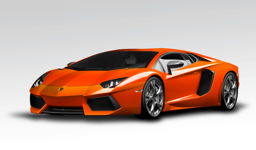

Found 1 images.


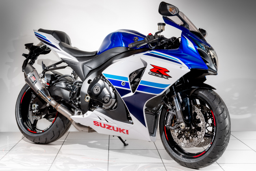

In [4]:
download_single_image("car photo", "images/cars/car.jpg")
download_single_image("motorbike photo", "images/motorbikes/motorbike.jpg")

In [5]:
def download_and_store_images(searches: list[str], filepath: str) -> None:
    destination: Path
    for image_type in searches:
        destination = Path(f"{filepath}/{image_type}")
        destination.mkdir(exist_ok=True, parents=True)
        download_images(destination, urls=search_images(f"{image_type} photo"))
        time.sleep(5)
        resize_images(destination, max_size=400, dest=destination)

    # Verify and remove invalid images
    images = get_image_files(destination)
    failed_images = [img for img in images if not verify_image(img)]
    for image in failed_images:
        image.unlink()

    print(f"Removed {len(failed_images)} corrupted images")

Remove corrupted / failed downloaded images from our dataset

In [6]:
download_and_store_images(["cars", "motorbikes"], "images/")

Found 200 images.
Found 200 images.
Removed 9 corrupted images


In [7]:
def verify_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify image integrity
        return True
    except (UnidentifiedImageError, OSError):
        return False

def clean_invalid_images(folder):
    images = get_image_files(folder)
    for img in images:
        if not verify_image(img):
            print(f"Removing corrupted image: {img}")
            img.unlink()

# Apply to your dataset
clean_invalid_images("images/")

Removing corrupted image: images\cars\5c1a9f8f-4a4a-434f-9860-5d6f47c49637.jpg
Removing corrupted image: images\cars\81b64f70-c0b1-4bc8-8dab-1e055a55cbd9.png
Removing corrupted image: images\cars\8cef2ab2-63fb-42e6-876a-6c8500201ece.jpg
Removing corrupted image: images\cars\adc9ce13-d3db-4293-a2de-ba7813127fd2.jpg


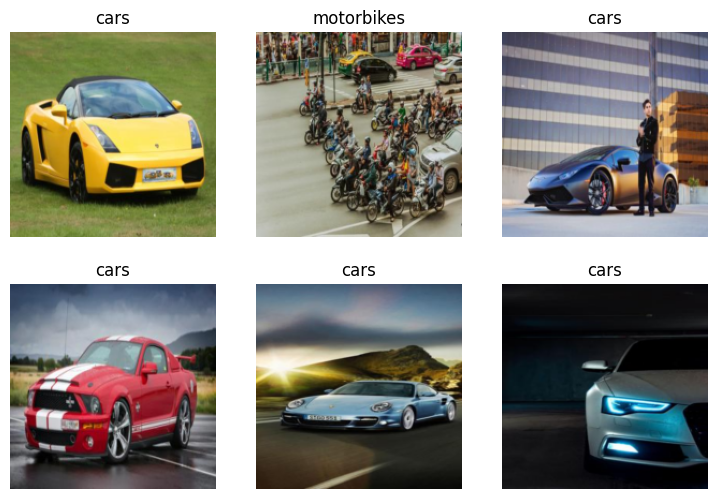

In [8]:
data_loader = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(Path("images/"), bs=32)

data_loader.show_batch(max_n=6)


In [9]:
learn = vision_learner(data_loader, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.449396,0.000978,0.000000,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.028773,0.000351,0.000000,00:51
1,0.025580,0.000233,0.000000,00:55
2,0.025544,0.000321,0.000000,00:56


In [10]:
is_car, _, probs = learn.predict(PILImage.create("images/cars/car.jpg"))
print(f"This is an image of {is_car}.")
print(f"Probability it's a car: {probs[0]:.4f}")

This is an image of cars.
Probability it's a car: 1.0000
